<a href="https://colab.research.google.com/github/harsh51380/harsh51380/blob/main/major_project_ediglobe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import os
import gc
import warnings
from typing import List, Optional, Tuple, Dict, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
import joblib

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (10, 5)

In [11]:
DATA_PATH = '/content/drive/MyDrive/majorproject/wind_turbine_data.csv'
DATETIME_COL = 'timestamp'
TARGET_COL = 'Target'
ID_COL = 'turbine_id'
SAMPLE_FRAC = None
RANDOM_STATE = 42
MODEL_OUTPUT = 'greenwatt_model.pkl'

In [12]:
df = pd.read_csv(DATA_PATH)


In [13]:
try:
    import lightgbm as lgb
    LGB_INSTALLED = True
except Exception:
    LGB_INSTALLED = False

try:
    import optuna
    OPTUNA_INSTALLED = True
except Exception:
    OPTUNA_INSTALLED = False

try:
    import shap
    SHAP_INSTALLED = True
except Exception:
    SHAP_INSTALLED = False


In [14]:
def load_data(path: str) -> pd.DataFrame:
    if path.endswith('.parquet'):
        return pd.read_parquet(path)
    return pd.read_csv(path)

def basic_cleaning(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.strip() if isinstance(c, str) else c for c in df.columns]
    if DATETIME_COL in df.columns:
        df[DATETIME_COL] = pd.to_datetime(df[DATETIME_COL], infer_datetime_format=True, errors='coerce')
    df = df.drop_duplicates()
    return df


In [15]:
def engineer_time_features(df: pd.DataFrame) -> pd.DataFrame:
    if DATETIME_COL in df.columns and pd.api.types.is_datetime64_any_dtype(df[DATETIME_COL]):
        df['hour'] = df[DATETIME_COL].dt.hour
        df['day'] = df[DATETIME_COL].dt.day
        df['weekday'] = df[DATETIME_COL].dt.weekday
        df['month'] = df[DATETIME_COL].dt.month
        df['dayofyear'] = df[DATETIME_COL].dt.dayofyear
        df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
        df['month_sin'] = np.sin(2 * np.pi * (df['month'] - 1) / 12)
        df['month_cos'] = np.cos(2 * np.pi * (df['month'] - 1) / 12)
    return df

def rolling_features(df: pd.DataFrame, cols: List[str], windows: Tuple[int, ...] = (3, 6, 12)) -> pd.DataFrame:
    df = df.copy()
    if ID_COL in df.columns and DATETIME_COL in df.columns:
        df = df.sort_values([ID_COL, DATETIME_COL])
        grp = df.groupby(ID_COL)
        for c in cols:
            for w in windows:
                df[f'{c}_rmean_{w}'] = grp[c].transform(lambda x: x.rolling(window=w, min_periods=1).mean())
                df[f'{c}_rstd_{w}'] = grp[c].transform(lambda x: x.rolling(window=w, min_periods=1).std())
                df[f'{c}_lag_{w}'] = grp[c].transform(lambda x: x.shift(w))
    else:
        df = df.sort_values(DATETIME_COL) if DATETIME_COL in df.columns else df
        for c in cols:
            for w in windows:
                df[f'{c}_rmean_{w}'] = df[c].rolling(window=w, min_periods=1).mean()
                df[f'{c}_rstd_{w}'] = df[c].rolling(window=w, min_periods=1).std()
                df[f'{c}_lag_{w}'] = df[c].shift(w)
    return df

def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = engineer_time_features(df)

    if 'wind_speed' in df.columns:
        df['wind_speed_sq'] = df['wind_speed'] ** 2
        df['wind_speed_cube'] = df['wind_speed'] ** 3
    if 'wind_speed' in df.columns and 'turbine_temperature' in df.columns:
        df['wind_temp_inter'] = df['wind_speed'] * df['turbine_temperature']
    if 'generator_speed' in df.columns and 'turbine_temperature' in df.columns:
        df['gen_temp_inter'] = df['generator_speed'] * df['turbine_temperature']

    if ID_COL in df.columns and DATETIME_COL in df.columns:
        df = df.sort_values([ID_COL, DATETIME_COL])

    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    exclude_for_rolling = {TARGET_COL, 'hour', 'day', 'weekday', 'month', 'dayofyear', 'is_weekend',
                          'hour_sin', 'hour_cos', 'month_sin', 'month_cos'}
    numeric_roll_cols = [c for c in numeric_cols if c not in exclude_for_rolling]

    if numeric_roll_cols:
        df = rolling_features(df, numeric_roll_cols, windows=(3, 6, 12))

    df = df.replace([np.inf, -np.inf], np.nan)
    return df


In [16]:
def prepare_train_test(df: pd.DataFrame, features: List[str], test_size_days: Optional[int] = None
                       ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Index, pd.Index]:
    df = df.copy()
    if DATETIME_COL in df.columns and pd.api.types.is_datetime64_any_dtype(df[DATETIME_COL]):
        df = df.sort_values(DATETIME_COL)
        if test_size_days is not None and ID_COL in df.columns:
            train_parts = []
            test_parts = []
            for tid, grp in df.groupby(ID_COL):
                max_dt = grp[DATETIME_COL].max()
                cutoff = max_dt - pd.Timedelta(days=test_size_days)
                train_parts.append(grp[grp[DATETIME_COL] <= cutoff])
                test_parts.append(grp[grp[DATETIME_COL] > cutoff])
            train = pd.concat(train_parts).sort_values(DATETIME_COL)
            test = pd.concat(test_parts).sort_values(DATETIME_COL)
            if train.empty or test.empty:
                cutoff = df[DATETIME_COL].quantile(0.8)
                train = df[df[DATETIME_COL] <= cutoff]
                test = df[df[DATETIME_COL] > cutoff]
        else:
            cutoff = df[DATETIME_COL].quantile(0.8)
            train = df[df[DATETIME_COL] <= cutoff]
            test = df[df[DATETIME_COL] > cutoff]
    else:
        train, test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)

    X_train = train[features].copy()
    y_train = train[TARGET_COL].copy()
    X_test = test[features].copy()
    y_test = test[TARGET_COL].copy()
    return X_train, X_test, y_train, y_test, train.index, test.index

In [17]:
def build_pipeline() -> Pipeline:
    imputer = SimpleImputer(strategy='median')
    scaler = StandardScaler()
    return Pipeline([('imputer', imputer), ('scaler', scaler)])

def train_model(X_train: np.ndarray, y_train: np.ndarray,
                X_valid: Optional[np.ndarray] = None, y_valid: Optional[np.ndarray] = None):
    if LGB_INSTALLED:
        train_data = lgb.Dataset(X_train, label=y_train)
        valid_sets = [train_data]
        valid_names = ['train']
        if X_valid is not None and y_valid is not None:
            valid = lgb.Dataset(X_valid, label=y_valid)
            valid_sets.append(valid)
            valid_names.append('valid')
        params = {
            'objective': 'regression',
            'metric': ['rmse', 'mae'],
            'learning_rate': 0.05,
            'num_leaves': 31,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'seed': RANDOM_STATE,
            'verbosity': -1,
        }
        callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=False), lgb.log_evaluation(period=200)]
        model = lgb.train(params, train_data, num_boost_round=2000, valid_sets=valid_sets, valid_names=valid_names, callbacks=callbacks)
        return model
    else:
        rf = RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
        rf.fit(X_train, y_train)
        return rf


In [18]:
def evaluate_model(model, X: pd.DataFrame, y: pd.Series, pipeline: Optional[Pipeline] = None) -> Tuple[Dict[str, float], np.ndarray]:
    if pipeline is not None:
        X_proc = pipeline.transform(X)
    else:
        X_proc = X.values if hasattr(X, 'values') else X

    if LGB_INSTALLED and isinstance(model, lgb.Booster):
        num_iter = getattr(model, 'best_iteration', None)
        y_pred = model.predict(X_proc, num_iteration=num_iter)
    else:
        y_pred = model.predict(X_proc)

    y_arr = np.array(y)
    y_pred_arr = np.array(y_pred)
    mae = float(np.mean(np.abs(y_arr - y_pred_arr)))
    rmse = float(np.sqrt(np.mean((y_arr - y_pred_arr) ** 2)))
    try:
        r2 = float(r2_score(y_arr, y_pred_arr))
    except Exception:
        r2 = float('nan')
    return {'rmse': rmse, 'mae': mae, 'r2': r2}, y_pred_arr

In [19]:
def predict_batch(model, pipeline: Pipeline, df: pd.DataFrame, features: List[str]) -> np.ndarray:
    X = df[features].copy()
    X_proc = pipeline.transform(X)
    if LGB_INSTALLED and isinstance(model, lgb.Booster):
        num_iter = getattr(model, 'best_iteration', None)
        preds = model.predict(X_proc, num_iteration=num_iter)
    else:
        preds = model.predict(X_proc)
    return np.array(preds)


In [20]:
def run_full_pipeline(data_path: Optional[str] = None,
                      sample_frac: Optional[float] = None,
                      test_size_days: Optional[int] = None,
                      save_model: bool = True) -> Dict[str, Any]:
    data_path = data_path or DATA_PATH
    sample_frac = SAMPLE_FRAC if sample_frac is None else sample_frac

    print('\nLoading data from:', data_path)
    df = load_data(data_path)
    print('Raw data shape:', df.shape)

    if sample_frac is not None:
        if not (0 < sample_frac <= 1):
            raise ValueError('sample_frac must be between 0 and 1')
        df = df.sample(frac=sample_frac, random_state=RANDOM_STATE).reset_index(drop=True)
        print('Sampled data shape:', df.shape)

    df = basic_cleaning(df)

    if TARGET_COL not in df.columns:
        raise ValueError(f"Target column '{TARGET_COL}' not found in data")

    print('Engineering features...')
    df = feature_engineering(df)

    # drop rows with NaN target
    df = df[df[TARGET_COL].notna()].copy()
    if df.empty:
        raise ValueError('No rows left after dropping NaN targets')

    exclude = {TARGET_COL}
    if DATETIME_COL in df.columns: exclude.add(DATETIME_COL)
    if ID_COL in df.columns: exclude.add(ID_COL)
    candidate_features = [c for c in df.columns if c not in exclude and pd.api.types.is_numeric_dtype(df[c])]
    print('Total numeric candidate features:', len(candidate_features))

    if candidate_features:
        missing_frac = df[candidate_features].isna().mean()
        candidate_features = [c for c in candidate_features if missing_frac.get(c, 0) < 0.5]

    features = candidate_features
    if not features:
        raise ValueError('No usable features found after filtering')

    print('Final features (sample):', features[:12])

    X_train, X_test, y_train, y_test, train_idx, test_idx = prepare_train_test(df, features, test_size_days=test_size_days)
    print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

    pipeline = build_pipeline()
    pipeline.fit(X_train)

    X_train_proc = pipeline.transform(X_train)
    X_test_proc = pipeline.transform(X_test)

    if len(X_train_proc) > 50:
        X_tr_sub, X_val_sub, y_tr_sub, y_val_sub = train_test_split(X_train_proc, y_train, test_size=0.15, random_state=RANDOM_STATE)
    else:
        X_tr_sub, y_tr_sub = X_train_proc, y_train
        X_val_sub, y_val_sub = None, None

    print('Training model...')
    model = train_model(X_tr_sub, y_tr_sub, X_valid=X_val_sub, y_valid=y_val_sub)

    print('Evaluating model on train and test sets...')
    train_metrics, train_pred = evaluate_model(model, X_train, y_train, pipeline=pipeline)
    test_metrics, test_pred = evaluate_model(model, X_test, y_test, pipeline=pipeline)

    print('Train metrics:', train_metrics)
    print('Test metrics:', test_metrics)

    if save_model:
        meta = {
            'features': features,
            'train_metrics': train_metrics,
            'test_metrics': test_metrics,
            'train_date': pd.Timestamp.now(),
            'pipeline_version': 1
        }
        joblib.dump({'model': model, 'pipeline': pipeline, 'meta': meta}, MODEL_OUTPUT)
        print('Saved model + pipeline + meta to', MODEL_OUTPUT)

    df_out = df.copy()
    df_out.loc[X_test.index, 'y_pred'] = test_pred

    gc.collect()

    return {
        'model': model,
        'pipeline': pipeline,
        'features': features,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'df': df_out
    }


In [21]:
def plot_feature_importance(model, features: List[str], top_n: int = 20):
    if LGB_INSTALLED and isinstance(model, lgb.Booster):
        imp = pd.DataFrame({'feature': features, 'importance': model.feature_importance(importance_type='gain')})
        imp = imp.sort_values('importance', ascending=False).reset_index(drop=True)
        top = imp.head(top_n).iloc[::-1]
        plt.figure(figsize=(8, max(4, 0.25 * len(top))))
        plt.barh(top['feature'], top['importance'])
        plt.title('Top Feature Importances (gain)')
        plt.tight_layout()
        plt.show()
    else:
        print('Feature importance plotting is only available for LightGBM in this script.')

def plot_predictions(df_res: pd.DataFrame, n: int = 300):
    test_df = df_res[df_res['y_pred'].notna()].copy()
    n = min(n, len(test_df))
    if n == 0:
        print('No test predictions to plot.')
        return
    plt.figure(figsize=(12, 4))
    plt.plot(test_df[TARGET_COL].values[:n], label='Actual', linewidth=2)
    plt.plot(test_df['y_pred'].values[:n], label='Predicted', linestyle='--', linewidth=2)
    plt.xlabel('Sample Index')
    plt.ylabel(TARGET_COL)
    plt.title('Predicted vs Actual (sample)')
    plt.legend()
    plt.grid(True)
    plt.show()

    errors = test_df[TARGET_COL].values - test_df['y_pred'].values
    plt.figure(figsize=(8, 4))
    plt.hist(errors, bins=50, edgecolor='black')
    plt.title('Prediction Error Distribution (Actual - Predicted)')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 6))
    plt.scatter(test_df[TARGET_COL], test_df['y_pred'], alpha=0.4)
    mn = min(test_df[TARGET_COL].min(), test_df['y_pred'].min())
    mx = max(test_df[TARGET_COL].max(), test_df['y_pred'].max())
    plt.plot([mn, mx], [mn, mx], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')
    plt.grid(True)
    plt.show()


Loading data from: /content/drive/MyDrive/majorproject/wind_turbine_data.csv
Raw data shape: (909604, 16)
Engineering features...
Total numeric candidate features: 140
Final features (sample): ['active_power_calculated_by_converter', 'active_power_raw', 'ambient_temperature', 'generator_speed', 'generator_winding_temp_max', 'grid_power10min_average', 'nc1_inside_temp', 'nacelle_temp', 'reactice_power_calculated_by_converter', 'reactive_power', 'wind_direction_raw', 'wind_speed_raw']
Train shape: (727683, 140) Test shape: (181921, 140)
Training model...
[200]	train's rmse: 1.13533	train's l1: 0.794015	valid's rmse: 1.14901	valid's l1: 0.799055
[400]	train's rmse: 1.00333	train's l1: 0.71082	valid's rmse: 1.02963	valid's l1: 0.721253
[600]	train's rmse: 0.927003	train's l1: 0.661609	valid's rmse: 0.960848	valid's l1: 0.675468
[800]	train's rmse: 0.87006	train's l1: 0.624269	valid's rmse: 0.90975	valid's l1: 0.641356
[1000]	train's rmse: 0.827075	train's l1: 0.596609	valid's rmse: 0.8723

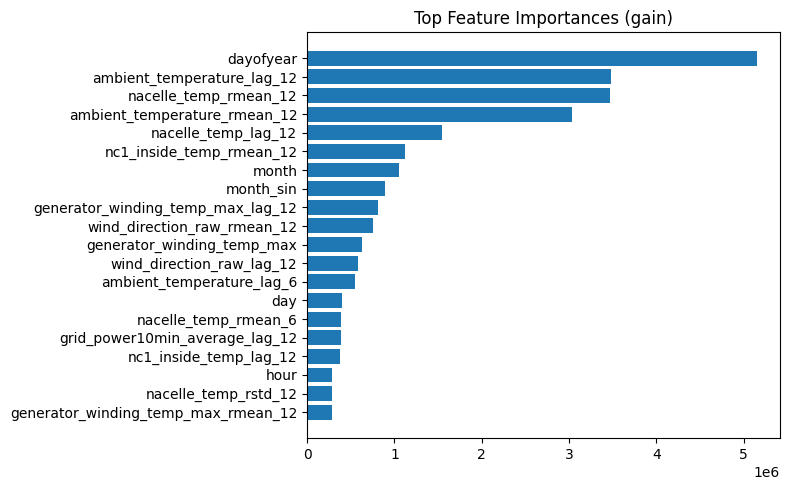

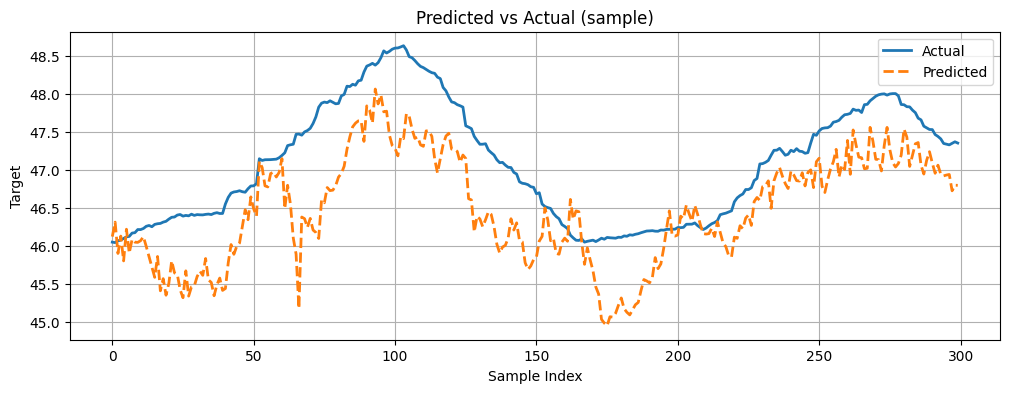

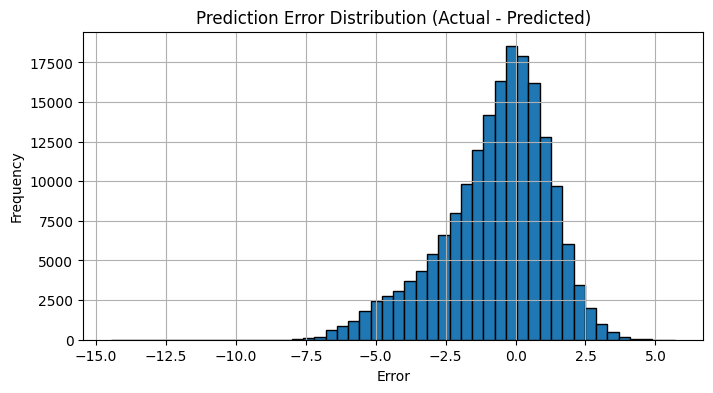

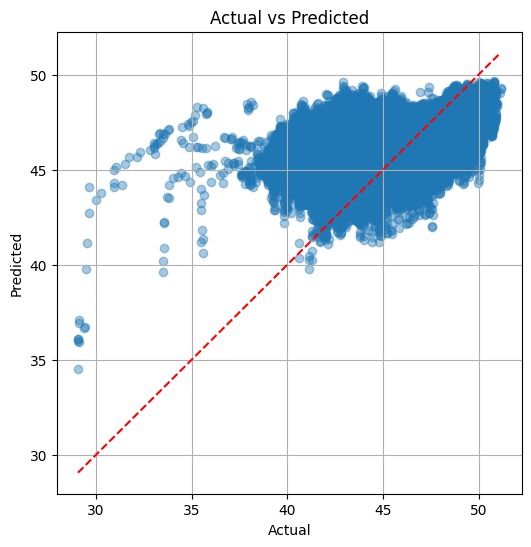


Inference demo (first 5 test rows):
      actual  predicted
0  46.050399  46.123147
1  46.044201  46.313966
2  46.068531  45.901249
3  46.076389  46.129924
4  46.099153  45.802836


In [22]:
if __name__ == '__main__':
    try:
        results = run_full_pipeline(data_path=DATA_PATH, sample_frac=SAMPLE_FRAC, test_size_days=None, save_model=True)
    except Exception as e:
        print('Error running pipeline:', e)
        raise

    print('Pipeline completed')

    model = results['model']
    pipeline = results['pipeline']
    features = results['features']
    df_res = results['df']
    df_test = df_res[df_res['y_pred'].notna()].copy()
    if not df_test.empty:
        y_true = df_test[TARGET_COL].values
        y_pred = df_test['y_pred'].values
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        accuracy = 1 - (mae / np.mean(np.abs(y_true)))
        print("")
        print("Final Regression Performance Metrics (on test partition):")
        print(f"MAE: {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"R²: {r2:.4f}")
        print(f"Approx. Accuracy (1 - MAE/mean(y)): {accuracy*100:.2f}%")
    else:
        print('No test partition predictions available to compute final metrics.')

    plot_feature_importance(model, features, top_n=20)
    plot_predictions(df_res, n=300)

    demo_df = df_res[df_res['y_pred'].notna()].head(5)
    if not demo_df.empty:
        preds = predict_batch(model, pipeline, demo_df, features)
        print('\nInference demo (first 5 test rows):')
        print(pd.DataFrame({'actual': demo_df[TARGET_COL].values, 'predicted': preds}))
    else:
        print('No test rows for inference demo.')